In [3]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport features.build_features
%aimport visualization.visualize
from features.build_features import read_raw_data
import numpy as np
import pandas as pd

Let's visualize the relationship between each feature (before transformation) and the target in a scatter plot. (PDF generated using src/visualization/visualize.py)

In [4]:
from IPython.display import HTML
HTML('<iframe src=../reports/figures/Features.pdf width=700 height=350></iframe>')

We see that the data clearly has some outliers. These should be removed before training the model to avoid overfitting. Furthermore as we saw earlier some features only have little variabiliy.
By looking at the plots we see some features are clear candidates for removal:
- Id (clearly we shouldn't make prediction based on Id)
- MoSold (the data seems to be more or less uniformly distributed)
- YrSold (the data seems to be more or less uniformly distributed)
- Street (almost all records have the same value)
- Utilities (almost all records have the same value)
- Condition2 (almost all records have the same value)
- LowQualFinSF (almost all records have the same value)
- 3SsnPorch (almost all records have the same value)
- PoolArea (almost all records have the same value)
- PoolQC (almost all records have the same value)

Let's confirm these latter observations by applying a threshold on the relative frequency of the value with the maximum frequency. 

In [5]:
df = read_raw_data("../data/raw/train.csv")
mask = []
for col in df.columns:
    mask.append(np.array(df[col].value_counts(True, dropna=False))[0] < 0.8)
print(df.columns[~np.array(mask)].shape)   
print(df.columns[~np.array(mask)]) 


(33,)
Index(['Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope',
       'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond',
       'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir',
       'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
       'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence',
       'MiscFeature', 'MiscVal', 'SaleType', 'SaleCondition'],
      dtype='object')


We see that out of the original 80 features, there are 33 for which one value occurs at least 80% of the time. This is however not a sufficient argument to exclude those features, as they could still be strongly correlated with the target feature. 

One method to reduce the features is to select the k features most correlated with the target (univariate feature selection). Another possibility is to train a model computing weight coefficients or feature importance. Finally such models can also be used in recursive feature elimination where features are removed step by step.

Let's try each of these methods to retain 10 features out of the transformed 264 and compare the retained features.

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

df = read_raw_data("../data/intermediate/eval.csv")
y = df['SalePrice']
X = df.drop(['SalePrice', 'Id'], axis=1)

selector = SelectKBest(mutual_info_regression, k=10)
selector.fit_transform(X, y)
mask_sk = selector.get_support()
print("Features retained with SelectKBest - mutual_info_regression :\n{}".format(X.columns[mask_sk]))

/anaconda/envs/Kaggle/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Features retained with SelectKBest - mutual_info_regression :
Index(['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', '1stFlrSF',
       'GrLivArea', 'FullBath', 'KitchenQual', 'GarageCars', 'GarageArea'],
      dtype='object')


In [25]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# need to scale data to apply Lasso model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso = Lasso(max_iter=50000).fit(X_scaled, y)
selectm = SelectFromModel(lasso)
selectm.fit_transform(X_scaled, y)
mask_sm = selectm.get_support()
print("Features retained with Lasso Regression :\n{}\n".format(X.columns[mask_sm]))
print("Features removed with Lasso Regression :\n{}".format(X.columns[~mask_sm]))

Features retained with Lasso Regression :
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'BsmtFinSF'],
      dtype='object', length=236)

Features removed with Lasso Regression :
Index(['1stFlrSF', 'MSSubClass_20', 'MSZoning_RL', 'Street_Pave',
       'LotShape_Reg', 'LandContour_Lvl', 'Utilities_NoSeWa',
       'LotConfig_Inside', 'LandSlope_Gtl', 'Neighborhood_Timber',
       'Condition1_PosN', 'Condition2_RRAn', 'BldgType_TwnhsE',
       'HouseStyle_SFoyer', 'RoofStyle_Gambrel', 'RoofMatl_CompShg',
       'Exterior1st_HdBoard', 'Exterior2nd_Plywood', 'Foundation_PConc',
       'Heating_Grav', 'CentralAir_Y', 'Functional_Min1', 'GarageType_Attchd',
       '

Interesting enough, the lasso model only reduces the number of features down to 239.
Let's see what happens when we use an ensemble method.

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

sgbr = GradientBoostingRegressor()
sgbr.fit(X, y)
selectmgb = SelectFromModel(sgbr)
selectmgb.fit_transform(X, y)
mask_smgb = selectmgb.get_support()
print("Features retained with Gradient Boosting Regression :\n{}\n".format(X.columns[mask_smgb]))
print("Features removed with Gradient Boosting Regression :\n{}".format(X.columns[~mask_smgb]))

Features retained with Gradient Boosting Regression :
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenQual',
       'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'PoolArea', 'MoSold',
       'MSZoning_C (all)', 'LotConfig_CulDSac', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_StoneBr',
       'Condition1_Artery', 'Condition1_Norm', 'Exterior1st_BrkFace',
       'Exterior2nd_MetalSd', 'BsmtFinType1_GLQ', 'Functional_Typ',
       'GarageType_Attchd', 'SaleType_New', 'SaleCondition_Abnorml',
       'SaleCondition_Family', 'BsmtFinSF'],
      dtype='object')

Features removed with Gradient Boosting Regression :
Index(['ExterC

The gradient boosting regression reduces the number of features to 47.
Let's see what happens when using recursive feature elimination (RFE) to reduce the number of features to 10.

In [18]:
from sklearn.feature_selection import RFE

rfegbr = GradientBoostingRegressor()
rfe = RFE(estimator=rfegbr, n_features_to_select=10, step=1)
rfe.fit(X, y)
mask_rfe = rfe.get_support()
print("Features retained with Recursive Feature Elimination - Gradient boosting regressor :\n{}".format(X.columns[mask_rfe]))

Features retained with Recursive Feature Elimination - Gradient boosting regressor :
Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'BsmtFinSF'],
      dtype='object')


The features retained with SelectK and RFE partially overlap. The lasso regression does not allow to eliminate a high number of features, whereas basing the feature selection on a gradient boosting regressor allows to limit the number of used features to 47.

As sometimes both GarageCars and GarageArea are selected, one can wonder whether they are redundant features.

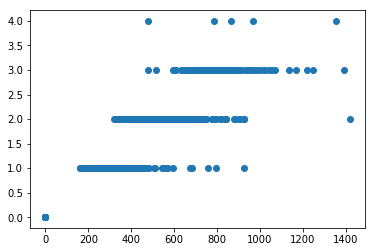

In [15]:
from matplotlib import pyplot as plt
plt.scatter(X['GarageArea'], X['GarageCars'])
plt.show()

Visibly those features cannot be considered redundant.

We arbitrarily fixed the number of features to retain with the RFE to 10. A more rigurous approach would be to select the number of features producing best results in a cross-validation.

In [19]:
from sklearn.feature_selection import RFECV

rfecvgbr = GradientBoostingRegressor()
rfecv = RFECV(estimator=rfecvgbr, step=1)
X_new = rfecv.fit_transform(X, y)
mask_rfecv = rfecv.get_support()
print("Features retained with Recursive Feature Elimination CV - Gradient boosting regressor :\n{}".format(X.columns[mask_rfecv]))
        

Features retained with Recursive Feature Elimination CV - Gradient boosting regressor :
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'KitchenAbvGr', 'KitchenQual', 'FireplaceQu',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'ScreenPorch', 'PoolArea', 'MoSold', 'MSSubClass_60',
       'MSZoning_C (all)', 'LotConfig_CulDSac', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_OldTown', 'Neighborhood_StoneBr',
       'Condition1_Artery', 'Condition1_Norm', 'Exterior1st_BrkFace',
       'BsmtFinType1_GLQ', 'Functional_Typ', 'GarageType_Attchd',
       'SaleType_New', 'SaleCondition_Abnorml', 'SaleCondition_Family',
       'BsmtFinSF'],
      dtype='object')


The RFE with cross-validation picks 44 features.